# Определение возраста покупателей

**Задача** - построение модели, определяющей по фото приблизительный возраст человека 

**Ключевые шаги**   
1. Исследовательский анализ данных;
2. Подготовка данных к обучению;
3. Обучение нейронной сети и проверка качества

**Описание**   
Нам предоставлен массив фотографий и соответствующий возраст человека по каждому фото.  
Супермаркет хочет ввести систему распознавания лиц покупателей для зоны касс, чтобы контролировать продажу спиртного и предлагать специальные предложения определённой возрастной группе

**Библиотеки**  
Pandas, matplotlib, tensorflow

## Исследовательский анализ данных

In [ ]:
!pip install tensorflow

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt
import pylab as pl

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Данные взяты с сайта "ChaLearn Looking at People"

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
print('Размер выборки:\n', labels.shape)

Размер выборки:
 (7591, 2)


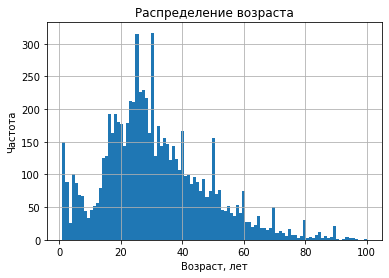

In [5]:
h = labels['real_age'].hist(bins=100);
pl.title('Распределение возраста');
h.set_xlabel("Возраст, лет");
h.set_ylabel("Частота");    

In [6]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


В датасете присутствуют возрастные данные по 7591 человеку и их фотографии. Возраст людей в выборке от 1 до 100 лет, в среднем - 31 год. 50% выборки составляют люди от 20 до 41 года, так как это основная аудитория интернет-страниц и аккаунтов в соц. сетях. На основе этого можем сделать вывод, что фотографий людей в возрасте 20-40 лет может быть достаточно для обучения, а младшего и более старшего возраста заметно меньше.

Можем отметить, что в значениях, кратных 10, можем наблюдать "пики", например, больше людей возраста 60 лет, чем 55 и 65. Это может быть связано с тем, что на старых фото отмечается приблизительный (округленный) возраст человека. Также фото могут чаще делать в честь юбилеев.   

In [7]:
def photo(i):
    image_filename = "/faces/00000%s.jpg" % i
    image = Image.open(image_filename)
    array = np.array(image)
    return array

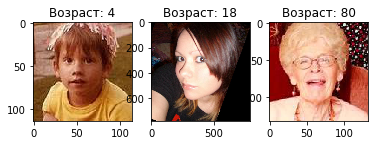

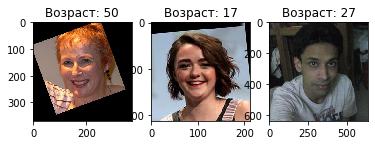

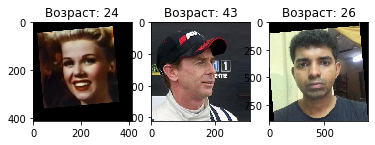

In [8]:
for i in range(0, 9, 3):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)    
    ax1.imshow(photo(i))
    ax1.set_title('Возраст: {}'.format(labels.loc[i, 'real_age']))
    ax2.imshow(photo(i+1))
    ax2.set_title('Возраст: {}'.format(labels.loc[i+1, 'real_age']))
    ax3.imshow(photo(i+2))
    ax3.set_title('Возраст: {}'.format(labels.loc[i+2, 'real_age']))

По 9-ти фото можем сказать, что люди соответсвуют указанному возрасту. Некоторые фото оказались смещены, повёрнуты или обрезаны. Некотрые фото засветлены, некоторые - затемнены. Также можно заметить, что на некоторых фото люди повёрнуты боком, или фото сделаны под разным углом.   
Возможная аугментация: повороты фото на 20-30 градусов, отображение фото по вертикали, изменение яркости.

## Обучение модели

Код обучения модели и её результат вывода перенесены в виде текста

```python

from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.0001)

datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255,
                         horizontal_flip=True, rotation_range=30, brightness_range=[0.8, 1.25], zoom_range=[0.5,1.0])


def load_train(path):
    
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_gen_flow



def load_test(path):
    
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_gen_flow



def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    backbone.trainable=True
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    
    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
   
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 

```

###  РЕЗУЛЬТАТЫ ВЫВОДА 
```

Train for 356 steps, validate for 119 steps
Epoch 1/10
2021-05-14 17:56:09.096586: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-05-14 17:56:12.601461: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 211s - loss: 247.5107 - mae: 11.5311 - val_loss: 567.7903 - val_mae: 18.7748
Epoch 2/10
356/356 - 131s - loss: 124.2753 - mae: 8.5563 - val_loss: 217.5798 - val_mae: 11.0083
Epoch 3/10
356/356 - 131s - loss: 105.1783 - mae: 7.8173 - val_loss: 130.0549 - val_mae: 8.7069
Epoch 4/10
356/356 - 131s - loss: 93.4252 - mae: 7.3934 - val_loss: 105.6259 - val_mae: 7.7562
Epoch 5/10
356/356 - 131s - loss: 84.8306 - mae: 7.0010 - val_loss: 139.2184 - val_mae: 9.2035
Epoch 6/10
356/356 - 131s - loss: 78.0287 - mae: 6.7199 - val_loss: 111.1168 - val_mae: 8.3044
Epoch 7/10
356/356 - 131s - loss: 73.3054 - mae: 6.5280 - val_loss: 103.5850 - val_mae: 7.6889
Epoch 8/10
356/356 - 132s - loss: 63.1782 - mae: 6.0940 - val_loss: 93.9123 - val_mae: 7.1128
Epoch 9/10
356/356 - 131s - loss: 63.1265 - mae: 6.0320 - val_loss: 91.9022 - val_mae: 7.2255
Epoch 10/10
356/356 - 131s - loss: 56.7684 - mae: 5.8093 - val_loss: 80.2875 - val_mae: 6.5482

```

## Анализ обученной модели

Мы попытались решить задачу регрессии - определение возраста. Так как для задачи нужен только один нейрон, была выбрана функция активации ReLu. По условию задачи необходимо было построить свёрточную сеть, а качество предсказания определить с помощью MAE. 

На первой эпохе можем заметить, что модель показывает склонность к переобучению, так как большая разница в результатах обучающей и валидационной выборок. Можем сказать, что лучшее качество каблюдается на 4ой эпохе: разница обучения и валидации наименьшая, после 4ой эпохи качество на валидационной выборке ухудшается